In [3]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from tqdm.notebook import tqdm
import os
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, MaxPool2D, Dropout, Concatenate
from tensorflow.keras.models import Model
from numba import cuda
from tensorflow.keras.models import load_model

In [5]:
device = cuda.get_current_device()
device.reset()

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
tf.test.is_built_with_cuda()

True

In [6]:
class ImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, x_folder_path, y_folder_path, x, y, batch_size = 1):
        super()
        self.x = x
        self.y = y
        self.x_folder_path = x_folder_path
        self.y_folder_path = y_folder_path
        self.batch_size = batch_size
        self.on_epoch_end()


    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, index):
        start_point = index * self.batch_size
        end_point = (index + 1) * self.batch_size
        batch_images = []
        batch_labels = []
        for i in range(start_point, end_point):
            image_x = cv2.imread(f'{self.x_folder_path}{self.x[i]}')
            image_x = cv2.resize(image_x, (IMG_WIDTH, IMG_HEIGHT))
            image_x = image_x / 255.
            batch_images.append(image_x)

            image_y = cv2.imread(f'{self.y_folder_path}{self.y[i]}')
            image_y = cv2.resize(image_y, (IMG_WIDTH, IMG_HEIGHT))
            image_y = image_y / 255.
            batch_labels.append(image_y)

        return np.array(batch_images), np.array(batch_labels)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.x))


In [7]:
dataset_x_path = 'custom_dataset_human_black_background/features/'
dataset_y_path = 'custom_dataset_human_black_background/labels/'

In [8]:
x_images = os.listdir(dataset_x_path)
y_images = os.listdir(dataset_y_path)

In [9]:
len(x_images), len(y_images)

(4731, 4731)

In [10]:
train_percentage = 0.8

In [11]:
train_image_ids = np.random.choice(len(x_images), int(len(x_images) * train_percentage), replace= False)
test_image_ids = np.delete(list(range(len(x_images))), train_image_ids)

In [12]:
len(train_image_ids), len(test_image_ids)

(3784, 947)

In [13]:
train_image_x = np.array(x_images)[train_image_ids]
train_image_y = np.array(y_images)[train_image_ids]
test_image_x = np.array(x_images)[test_image_ids]
test_image_y = np.array(y_images)[test_image_ids]

In [14]:
train_dataset = ImageGenerator(dataset_x_path, dataset_y_path, train_image_x, train_image_y, 32)
test_dataset = ImageGenerator(dataset_x_path, dataset_y_path, test_image_x, test_image_y, 32)

In [15]:
i = Input(shape = (IMG_HEIGHT, IMG_WIDTH, 3))

conv1_1 = Conv2D(32, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(i)
drop1 = Dropout(0.2)(conv1_1)
conv1_2 = Conv2D(32, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop1)
pool1 = MaxPool2D((2, 2))(conv1_2)

conv2_1 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(pool1)
drop2 = Dropout(0.2)(conv2_1)
conv2_2 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop2)
pool2 = MaxPool2D((2, 2))(conv2_2)

conv3_1 = Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(pool2)
drop3 = Dropout(0.2)(conv3_1)
conv3_2 = Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop3)
pool3 = MaxPool2D((2, 2))(conv3_2)

conv4_1 = Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(pool3)
drop4 = Dropout(0.2)(conv4_1)
conv4_2 = Conv2D(128, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop4)

up1 = Concatenate(-1)([UpSampling2D((2, 2))(conv4_2), conv3_2])
conv5_1 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(up1)
drop5 = Dropout(0.2)(conv5_1)
conv5_2 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop5)

up2 = Concatenate(-1)([UpSampling2D((2, 2))(conv5_2), conv2_2])
conv6_1 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(up2)
drop6 = Dropout(0.2)(conv6_1)
conv6_2 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop6)

up3 = Concatenate(-1)([UpSampling2D((2, 2))(conv6_2), conv1_2])
conv7_1 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(up3)
drop7 = Dropout(0.2)(conv7_1)
conv7_2 = Conv2D(64, (3, 3), activation= 'relu', kernel_initializer= 'he_normal', padding= 'same')(drop7)

segmentation = Conv2D(3, (1,1), activation= 'sigmoid', name='seg')(conv7_2)

model = Model(inputs = [i], outputs=[segmentation])

losses = {'seg': 'binary_crossentropy'}
metrics = {'seg': ['acc']}
model.compile(optimizer='adam', loss = losses, metrics=metrics)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 512, 512, 32  0           ['conv2d[0][0]']                 
                                )                                                             

In [17]:
history = model.fit(ImageGenerator(dataset_x_path, dataset_y_path, train_image_x, train_image_y), validation_data= ImageGenerator(dataset_x_path, dataset_y_path, test_image_x, test_image_y), epochs= 3, shuffle=True)

Epoch 1/3
3784/3784 [==============================] - 546s 141ms/step - loss: 0.4619 - acc: 0.2475 - val_loss: 0.4038 - val_acc: 0.4754
Epoch 2/3
3784/3784 [==============================] - 563s 149ms/step - loss: 0.3991 - acc: 0.1990 - val_loss: 0.3712 - val_acc: 0.0535
Epoch 3/3
3784/3784 [==============================] - 562s 148ms/step - loss: 0.3787 - acc: 0.1470 - val_loss: 0.4179 - val_acc: 0.2590


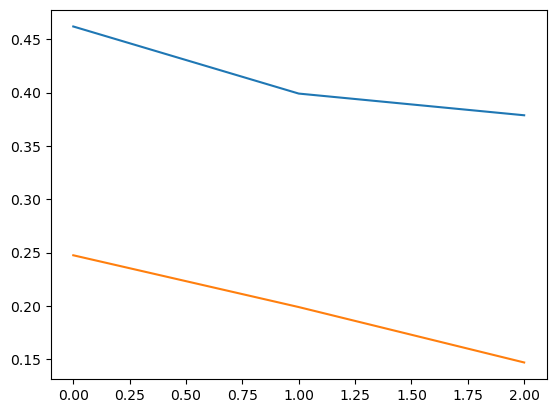

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

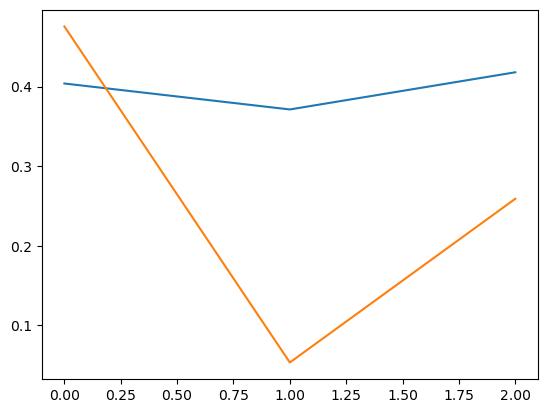

In [19]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_acc'])

In [20]:
def show_image(name, train = True):
    image = plt.imread(f'{dataset_x_path if train else dataset_y_path}{name}')
    plt.imshow(image)

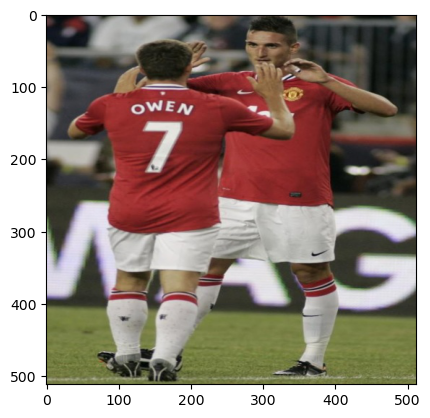

In [21]:
show_image(test_image_x[20])

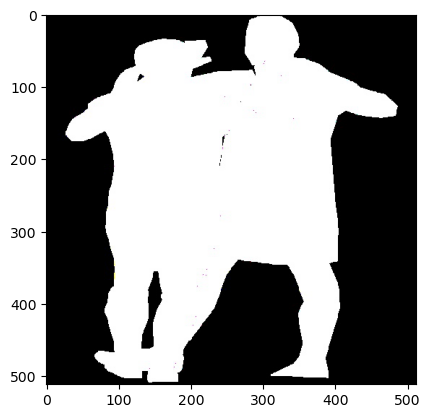

In [22]:
show_image(test_image_y[20],False)

In [42]:
image = plt.imread(f'{dataset_x_path}{test_image_x[20]}')
prediction = model.predict(np.array([image]))

1/1 [==============================] - 0s 29ms/step


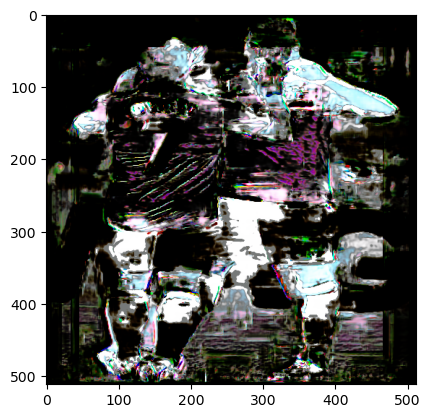

In [43]:
plt.imshow(prediction[0])

In [44]:
image.reshape(-1, 1).shape

(786432, 1)

In [45]:
prediction.reshape(-1, 1).shape

(786432, 1)

In [16]:
def new_mask(real_img, m_img):
    real_img = real_img.reshape(1, -1)[0]
    m_img = m_img.reshape(1, -1)[0]
    new = []

    for i, j in zip(real_img, m_img):
        if j > 0.8:
            new.append(i)
        else:
            new.append(0)
    
    new_np = np.array(new)
    new_np = new_np.reshape(512, 512, 3)
    return new_np

In [47]:
new_image = new_mask(image, prediction)

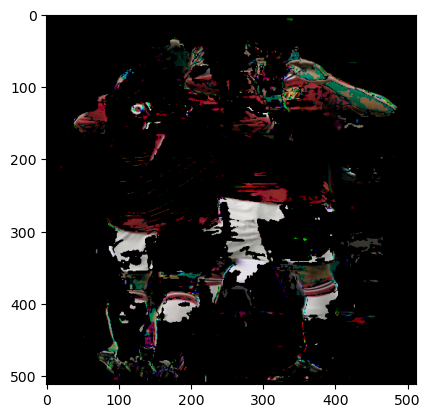

In [48]:
plt.imshow(new_image)

In [49]:
def blur_image(original_image, mask):
    blured_image = cv2.blur(original_image, (10, 10))
    original_image = original_image.reshape(1, -1)[0]
    mask = mask.reshape(1, -1)[0]
    blured_image = blured_image.reshape(1, -1)[0]
    new_image = []
    for i, j, k in zip(blured_image, mask, original_image):
        if j > 0.8:
            new_image.append(k)
        else:
            new_image.append(i)
    new_image = np.array(new_image).reshape(512, 512, 3)
    return new_image

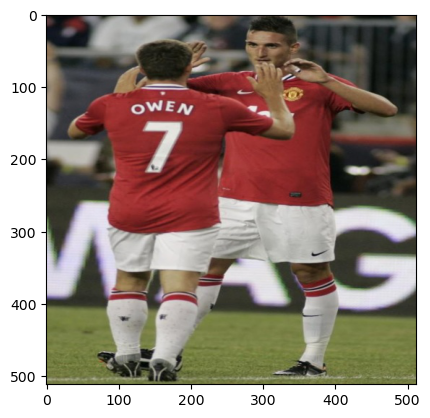

In [50]:
plt.imshow(image)

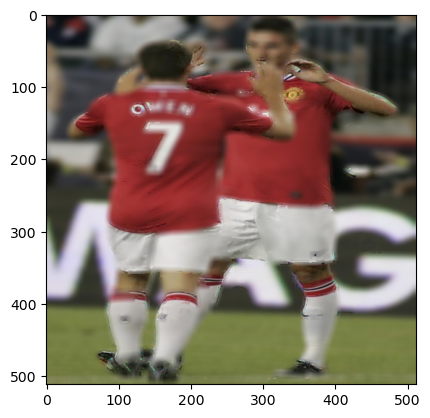

In [51]:
blurred_image = blur_image(image, prediction)
plt.imshow(blurred_image)

In [33]:
model.save("/volume/Programming/Jupyter/Image Segmentation/model.h5")

In [8]:
image_segmentor = load_model('model.h5', compile=False)
image_segmentor.compile()

In [20]:
vid = cv2.VideoCapture(0)

while True:
    ret, frame = vid.read()
    frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))
    segmentation = image_segmentor.predict(np.array([frame]))
    cv2.imshow('Image Segmentation', segmentation)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
vid.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 23ms/step
